# Notebook to evaluate a trained model with pyfolio
Note: pyfolio must be install using pip install git+https://github.com/quantopian/pyfolio. There are known bugs with pip install pyfolio.

In [98]:
import os
import datetime

import pandas as pd
import matplotlib
import pyfolio

from deep_rl_asset_allocation.configs import paths_config, data_config
from deep_rl_asset_allocation.utils import data_loader_utils

In [99]:
import warnings
warnings.filterwarnings('ignore')

In [100]:
# "Agg" backend is for writing to file, not for rendering in a window
# matplotlib.use('Agg')

# plotting in notebook
%matplotlib inline

### Helper Functions

In [101]:
def get_daily_return_as_df(df):
    df['daily_return'] = df.account_value.pct_change(1)
    # sharpe_ratio = (252**0.5) * df['daily_return'].mean() / df['daily_return'].std()
    # print(f'Sharpe Ratio: {sharpe_ratio*100:.2f} %')
    return df


def get_daily_return_as_series(df):
    df1 = df.copy()
    df1['Date'] = pd.to_datetime(df1['Date'])
    df1.set_index('Date', drop=False, inplace=True)
    df1.index = df1.index.tz_localize('UTC')
    del df1['Date']
    ts = pd.Series(df1['daily_return'].values, index=df1.index)
    return ts


def get_training_results_account_value(df_unique_trade_dates, results_csv_dir=paths_config.results_csv_dir):
    df_account_value = pd.DataFrame()
    for training_iteration, idx in enumerate(range(rebalance_window + validation_window, len(unique_trade_dates), rebalance_window)):
        asset_memory_csv_filename = os.path.join(results_csv_dir, f'total_asset_value_test_{training_iteration}.csv')
        df = pd.read_csv(asset_memory_csv_filename)
        df_account_value = df_account_value.append(df, ignore_index=True)
    # change the column name
    df_account_value = pd.DataFrame({'account_value': df_account_value['0']})
    # # get sharpe ratio
    # sharpe_ratio = (252**0.5) * df_account_value.account_value.pct_change(1).mean() / df_account_value.account_value.pct_change(1).std()
    # print(f'Sharpe Ratio: {sharpe_ratio*100:.2f} %')
    # merge with unique trade dates from 2016-01-04 or index 64
    df_account_value = df_account_value.join(df_unique_trade_dates.reset_index(drop=True))
    df_account_value = df_account_value[['date', 'account_value']]
    return df_account_value

### DJIA: Out-of-sample Test Data

In [102]:
# load DJIA - out of sample data (test data)
df_djia_out_of_sample = pd.read_csv(paths_config.TESTING_DATA_FILE)

In [103]:
# get data between dates
df_djia_out_of_sample = df_djia_out_of_sample[(df_djia_out_of_sample['Date'] >= str(data_config.TESTING_START)) & (df_djia_out_of_sample['Date'] <= str(data_config.TESTING_END))]
df_djia_out_of_sample = df_djia_out_of_sample.reset_index(drop=True)

# get daily return as relative difference in adjusted close price of DJIA
df_djia_out_of_sample['daily_return'] = df_djia_out_of_sample['Adj Close'].pct_change(1)

df_djia_out_of_sample

,Date,Open,High,Low,Close,Adj Close,Volume,daily_return
0,2016-01-04,17405.480469,17405.480469,16957.630859,17148.939453,17148.939453,148060000,NaN
1,2016-01-05,17147.500000,17195.839844,17038.609375,17158.660156,17158.660156,105750000,0.000567
2,2016-01-06,17154.830078,17154.830078,16817.619141,16906.509766,16906.509766,120250000,-0.014695
3,2016-01-07,16888.359375,16888.359375,16463.630859,16514.099609,16514.099609,176240000,-0.023211
4,2016-01-08,16519.169922,16651.890625,16314.570313,16346.450195,16346.450195,141850000,-0.010152
...,...,...,...,...,...,...,...,...
1090,2020-05-04,23581.550781,23769.560547,23361.160156,23749.759766,23749.759766,355360000,0.001099
1091,2020-05-05,23958.880859,24169.720703,23868.910156,23883.089844,23883.089844,369710000,0.005614
1092,2020-05-06,23978.880859,24054.589844,23661.140625,23664.640625,23664.640625,377450000,-0.009147
1093,2020-05-07,23837.210938,24094.619141,23834.390625,23875.890625,23875.890625,369890000,0.008927


In [104]:
series_djia_out_of_sample = get_daily_return_as_series(df_djia_out_of_sample)
series_djia_out_of_sample

Date
2016-01-04 00:00:00+00:00         NaN
2016-01-05 00:00:00+00:00    0.000567
2016-01-06 00:00:00+00:00   -0.014695
2016-01-07 00:00:00+00:00   -0.023211
2016-01-08 00:00:00+00:00   -0.010152
                               ...   
2020-05-04 00:00:00+00:00    0.001099
2020-05-05 00:00:00+00:00    0.005614
2020-05-06 00:00:00+00:00   -0.009147
2020-05-07 00:00:00+00:00    0.008927
2020-05-08 00:00:00+00:00    0.019075
Length: 1095, dtype: float64

### Load Training Results: Account Value

In [105]:
# load Dow 30 - in sample data (training data)
df_djia_in_sample = data_loader_utils.load_preprocessed_djia_data()

# rebalance_window is the number of months to retrain the model
rebalance_window = data_config.REBALANCE_WINDOW
# validation_window is the number of months to validation the model and select for trading
validation_window = data_config.VALIDATION_WINDOW

# get unique trade dates to load model results
unique_trade_dates = data_loader_utils.get_data_between_dates(df_djia_in_sample, start=data_config.VALIDATION_START, end=data_config.TESTING_END).date.unique()
df_unique_trade_dates = pd.DataFrame({'date': unique_trade_dates})

# filter for when Testing Starts
df_unique_trade_dates = df_unique_trade_dates[df_unique_trade_dates.date >= str(data_config.TESTING_START)]
df_unique_trade_dates.index = df_unique_trade_dates.date.factorize()[0]
df_unique_trade_dates

Found prevouisly saved pre-processed data: /Users/Aidan.Keaveny/git/deep-rl-asset-allocation/deep_rl_asset_allocation/data/csv/preprocessed_djia_data.csv


,date
0,2016-01-04
1,2016-01-05
2,2016-01-06
3,2016-01-07
4,2016-01-08
...,...
1089,2020-05-01
1090,2020-05-04
1091,2020-05-05
1092,2020-05-06


In [106]:
results_dir = os.path.join(paths_config.parent_dir, 'results')
results_trained_models_dir = os.path.join(results_dir, 'trained_models')
results_figs_dir = os.path.join(results_dir, 'figs')
results_csv_dir = os.path.join(results_dir, 'csv')

df_training_results_account_value = get_training_results_account_value(df_unique_trade_dates, results_csv_dir)
# df_training_results_account_value.account_value.plot()
df_training_results_account_value

,date,account_value
0,2016-01-04,1.000000e+06
1,2016-01-05,9.995243e+05
2,2016-01-06,9.966794e+05
3,2016-01-07,9.914018e+05
4,2016-01-08,9.882176e+05
...,...,...
1066,2020-03-30,1.746872e+06
1067,2020-03-31,1.746872e+06
1068,2020-04-01,1.746872e+06
1069,2020-04-02,1.746872e+06


In [107]:
# get daily return as relative difference in account value
df_training_results_account_value['daily_return'] = df_training_results_account_value.account_value.pct_change(1)

# compare dates with test date
df_training_results_account_value['Date'] = df_djia_out_of_sample['Date']
df_training_results_account_value = df_training_results_account_value[['date', 'Date', 'account_value', 'daily_return']]

df_training_results_account_value

,date,Date,account_value,daily_return
0,2016-01-04,2016-01-04,1.000000e+06,NaN
1,2016-01-05,2016-01-05,9.995243e+05,-0.000476
2,2016-01-06,2016-01-06,9.966794e+05,-0.002846
3,2016-01-07,2016-01-07,9.914018e+05,-0.005295
4,2016-01-08,2016-01-08,9.882176e+05,-0.003212
...,...,...,...,...
1066,2020-03-30,2020-03-30,1.746872e+06,0.000000
1067,2020-03-31,2020-03-31,1.746872e+06,0.000000
1068,2020-04-01,2020-04-01,1.746872e+06,0.000000
1069,2020-04-02,2020-04-02,1.746872e+06,0.000000


In [108]:
series_training_results_account_value = get_daily_return_as_series(df_training_results_account_value)  # [0:1097]
series_training_results_account_value

Date
2016-01-04 00:00:00+00:00         NaN
2016-01-05 00:00:00+00:00   -0.000476
2016-01-06 00:00:00+00:00   -0.002846
2016-01-07 00:00:00+00:00   -0.005295
2016-01-08 00:00:00+00:00   -0.003212
                               ...   
2020-03-30 00:00:00+00:00    0.000000
2020-03-31 00:00:00+00:00    0.000000
2020-04-01 00:00:00+00:00    0.000000
2020-04-02 00:00:00+00:00    0.000000
2020-04-03 00:00:00+00:00    0.000000
Length: 1071, dtype: float64

### Pyfolio

Start date,2016-01-04
End date,2020-04-03
Total months,51
,Backtest
Annual return,14.026%
Cumulative returns,74.687%
Annual volatility,8.608%
Sharpe ratio,1.57
Calmar ratio,2.72
Stability,0.97
Max drawdown,-5.159%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,5.16,2016-09-07,2016-11-03,2016-11-10,47
1,4.95,2016-06-08,2016-06-27,2016-07-08,23
2,4.61,2016-02-04,2016-02-11,2016-02-17,10
3,4.27,2016-01-04,2016-01-25,2016-02-04,24
4,4.23,2018-06-12,2018-06-27,2018-07-25,32


Stress Events,mean,min,max
New Normal,0.05%,-3.18%,2.88%


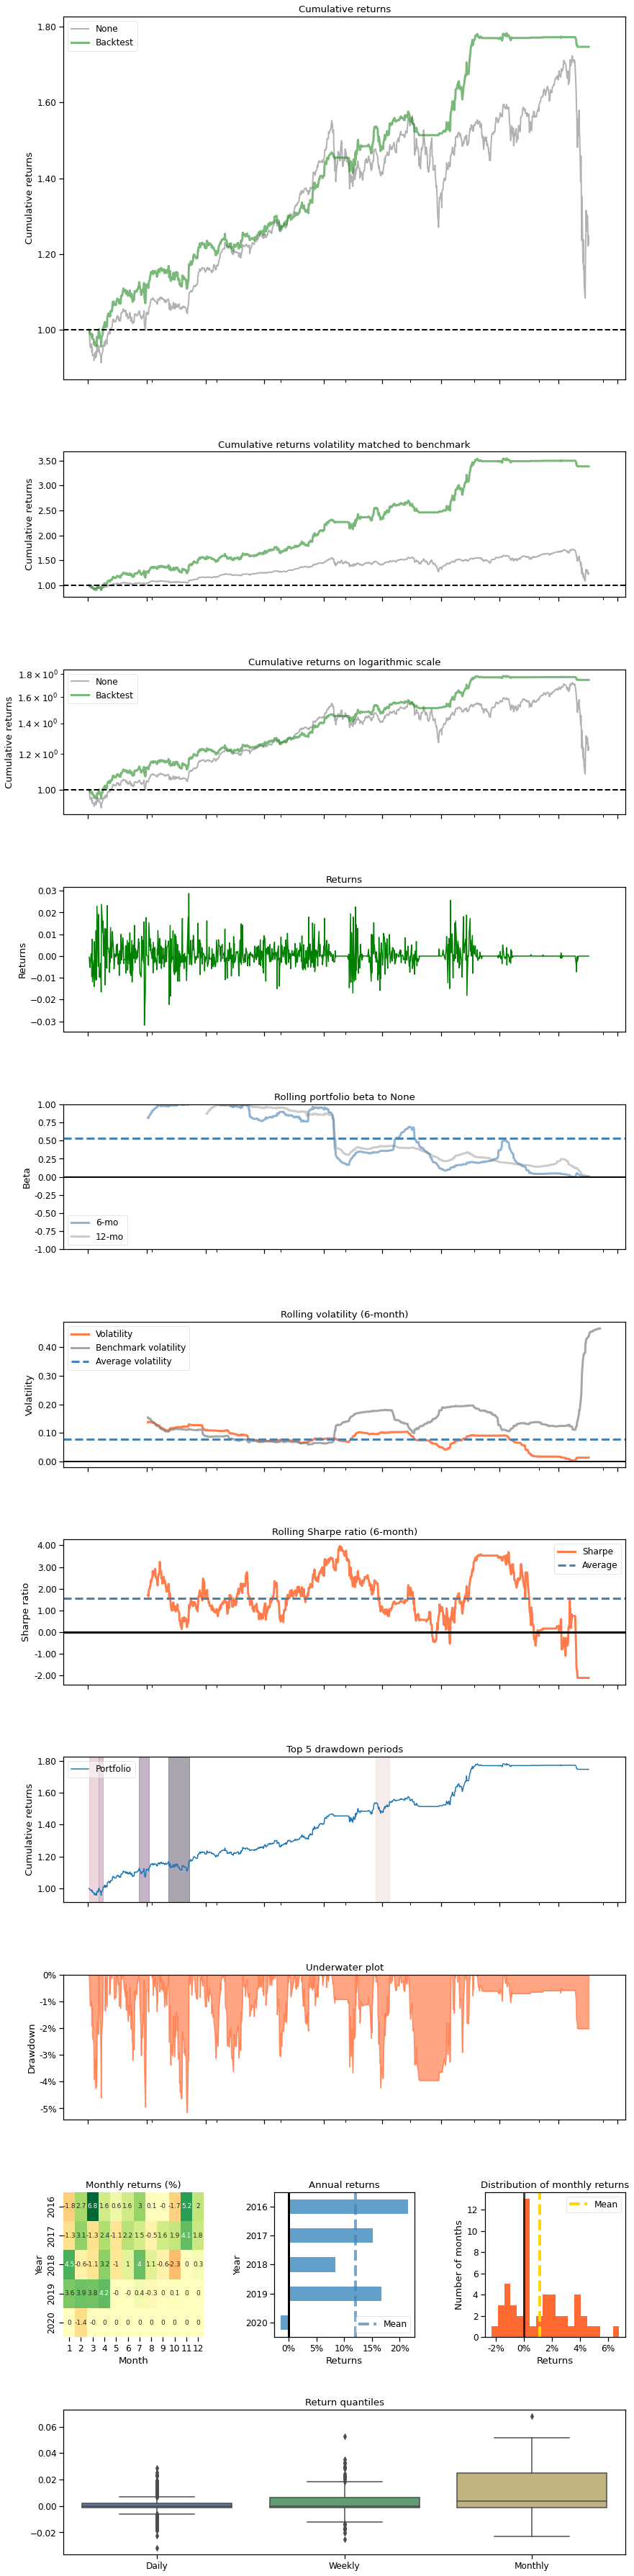

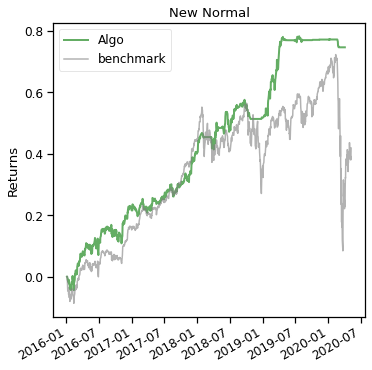

In [109]:
with pyfolio.plotting.plotting_context(font_scale=1.1):
    # pyfolio.create_full_tear_sheet(returns=series_djia_out_of_sample, set_context=False)
    pyfolio.create_full_tear_sheet(returns=series_training_results_account_value, benchmark_rets=series_djia_out_of_sample, set_context=False)